# Make the MPNN Model
We are going to layers from the [NFP](https://github.com/NREL/nfp) package from NREL to build out MPNN model.

NFP is built using Tensorflow. So, we will need to make a data loader that will generate TF-compatible data and a Keras Model object.
We use `tf.keras` for all operations so that we have a path forward to using this code with TF2.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from graphsage.mpnn.data import *
from graphsage.mpnn.layers import GraphNetwork, Squeeze
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tqdm import tqdm
import tensorflow as tf
import pickle as pkl
import numpy as np
import gzip
import json
import os

Configure TF for local GPU use

In [2]:
tf_config=tf.ConfigProto()
tf_config.gpu_options.allow_growth=True
sess = tf.Session(config=tf_config)

In [3]:
data_file = os.path.join('..', 'data', 'output', 'water_clusters.proto')

## Assemble Iterator
Make an iterator over the dataset that will generate batches of networks with each batch collapsed to a single "supernetwork"

In [4]:
r = make_data_loader(data_file, batch_size=32, shuffle_buffer=32768)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Get an example batch

In [5]:
with tf.Session() as sess:
    i = r.make_one_shot_iterator()
    batch = sess.run(i.get_next())

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Display the specification for the input data

In [6]:
r.element_spec

({'atom': TensorSpec(shape=(?,), dtype=tf.int64, name=None),
  'bond': TensorSpec(shape=(?,), dtype=tf.int64, name=None),
  'connectivity': TensorSpec(shape=(?, 2), dtype=tf.int64, name=None),
  'n_atom': TensorSpec(shape=(?,), dtype=tf.int64, name=None),
  'n_bond': TensorSpec(shape=(?,), dtype=tf.int64, name=None),
  'node_graph_indices': TensorSpec(shape=(?,), dtype=tf.int32, name=None),
  'bond_graph_indices': TensorSpec(shape=(?,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(?, 1), dtype=tf.float32, name=None))

We are not going to be saving the data loader. We'll remake it during the actual training procedure.

For now, we are using it for testing purposes.

See how random the batches are

In [7]:
batches = []
with tf.Session() as sess:
    n = r.make_one_shot_iterator().get_next()
    batches = [sess.run(n) for _ in tqdm(range(256))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 353.10it/s]


Plot the changes in the mean number of atoms

<ErrorbarContainer object of 3 artists>

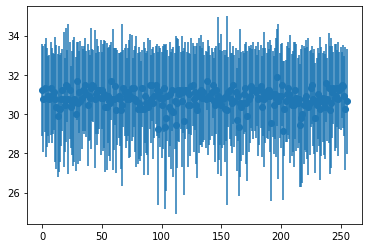

In [8]:
fig, ax = plt.subplots()

ax.errorbar(
    range(len(batches)),
    [b[0]['n_atom'].mean() for b in batches],
    fmt='o',
    yerr=[b[0]['n_atom'].std() for b in batches],
)

## Make the Model
Create the Keras Model object that describes the neural network.

In [9]:
def build_fn(atom_features=32, message_steps=8):
    node_graph_indices = Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = Input(shape=(1,), name='atom', dtype='int32')
    bond_types = Input(shape=(1,), name='bond', dtype='int32')
    connectivity = Input(shape=(2,), name='connectivity', dtype='int32')
    
    # Squeeze the node graph and connectivity matrices
    snode_graph_indices = Squeeze(axis=1)(node_graph_indices)
    satom_types = Squeeze(axis=1)(atom_types)
    sbond_types = Squeeze(axis=1)(bond_types)
    
    output = GraphNetwork(2, 2, atom_features,
                          message_steps, name='mpnn')([satom_types, sbond_types, snode_graph_indices, connectivity])
    
    return Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity],
                 outputs=output)

In [10]:
network = build_fn()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We know the average energy for each atom, and will use it to help the network start out near the correct solution

In [11]:
atom_energy = np.mean(batch[1][:, 0] / batch[0]['n_atom'])

In [12]:
l = network.get_layer('mpnn')

In [13]:
weights = l.atom_mean.get_weights()

In [14]:
weights[0][:] = atom_energy

In [15]:
l.atom_mean.set_weights(weights)

Print out the performance without any training

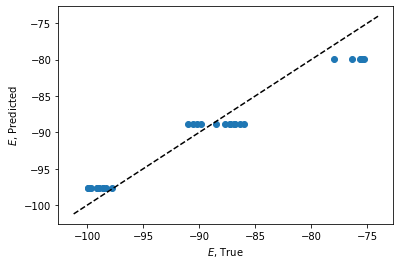

In [16]:
fig, ax = plt.subplots()

pred_y = network.predict_on_batch(batch[0])
ax.scatter(batch[1], pred_y)

ax.set_ylabel('$E$, Predicted')
ax.set_xlabel('$E$, True')

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

Save model to disk

In [17]:
network.save('model.h5')